In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [56]:
# function for a dict[KO] -> [pathway, subcategory]

def create_pathway_dict(KO_file):
    data = pd.read_csv(KO_file, on_bad_lines='skip', sep = "\t")
    data.columns = ["KOcategory", "subcategory", "Pathway", "KOterm", "Function", "Description"]
    KO_pathway_dict = {}
    for i in range(len(data["KOterm"])):
        KO_pathway_dict[data["KOterm"][i]] = [data["KOcategory"][i], data["subcategory"][i]]
    return KO_pathway_dict
    

In [58]:
KOcategory_dict = create_pathway_dict("./br_ko00001.tab.txt")

In [106]:
print(KOcategory_dict)

{'K00844': ['Brite Hierarchies', 'Protein families: genetic information processing'], 'K12407': ['Human Diseases', 'Endocrine and metabolic disease'], 'K00845': ['Metabolism', 'Biosynthesis of other secondary metabolites'], 'K25026': ['Metabolism', 'Biosynthesis of other secondary metabolites'], 'K01810': ['Brite Hierarchies', 'Protein families: signaling and cellular processes'], 'K06859': ['Metabolism', 'Carbohydrate metabolism'], 'K13810': ['Metabolism', 'Carbohydrate metabolism'], 'K15916': ['Metabolism', 'Carbohydrate metabolism'], 'K24182': ['Metabolism', 'Energy metabolism'], 'K00850': ['Brite Hierarchies', 'Protein families: genetic information processing'], 'K16370': ['Metabolism', 'Energy metabolism'], 'K21071': ['Metabolism', 'Energy metabolism'], 'K00918': ['Metabolism', 'Energy metabolism'], 'K00895': ['Metabolism', 'Carbohydrate metabolism'], 'K03841': ['Brite Hierarchies', 'Protein families: signaling and cellular processes'], 'K02446': ['Metabolism', 'Energy metabolism'

In [303]:
# for each bacteria get the info of what pathways

def get_pathway_for_bacteria(bacteria_kegg_results_file, KOcategory_dict_):
    list_genename_KO = []
    with open(bacteria_kegg_results_file, "r") as keggfile:
        for line in keggfile.readlines()[2:]:
            gene_name = line.split()[1]
            KO = line.split()[2]
            list_genename_KO.append((gene_name, KO))
    KO_distr_dict = {}
    for i in range(len(list_genename_KO)):
        KO = list_genename_KO[i][1]
        if KO in KOcategory_dict_.keys():
            pathway_major = KOcategory_dict_[KO][0]
            pathway_minor = KOcategory_dict_[KO][1]
            if pathway_major == "Brite Hierarchies" or "Not Included in Pathway or Brite" in pathway_major:
                continue
            if pathway_major+":"+pathway_minor in KO_distr_dict.keys():
                KO_distr_dict[pathway_major+":"+pathway_minor] += 1
            else:
                KO_distr_dict[pathway_major+":"+pathway_minor] = 1
    return dict(sorted(KO_distr_dict.items(), key=lambda item: item[0]))
    
    

In [304]:
p13_distr = get_pathway_for_bacteria("./p13kegg.txt", KOcategory_dict)

In [305]:
p50071_distr = get_pathway_for_bacteria("./p50071kegg.txt", KOcategory_dict)

In [306]:
p8_distr = get_pathway_for_bacteria("./p8kegg.txt", KOcategory_dict)

In [307]:
p4_distr = get_pathway_for_bacteria("./p4kegg.txt", KOcategory_dict)

In [308]:
p3_distr = get_pathway_for_bacteria("./p3kegg.txt", KOcategory_dict)

In [309]:
p13_distr

{'Cellular Processes:Cell growth and death': 5,
 'Cellular Processes:Cellular community - prokaryotes': 79,
 'Cellular Processes:Transport and catabolism': 5,
 'Environmental Information Processing:Membrane transport': 1,
 'Environmental Information Processing:Signal transduction': 47,
 'Genetic Information Processing:Folding, sorting and degradation': 11,
 'Genetic Information Processing:Translation': 3,
 'Human Diseases:Cancer: overview': 2,
 'Human Diseases:Cardiovascular disease': 7,
 'Human Diseases:Drug resistance: antimicrobial': 10,
 'Human Diseases:Drug resistance: antineoplastic': 6,
 'Human Diseases:Endocrine and metabolic disease': 15,
 'Human Diseases:Infectious disease: bacterial': 5,
 'Human Diseases:Infectious disease: parasitic': 1,
 'Human Diseases:Neurodegenerative disease': 7,
 'Human Diseases:Substance dependence': 3,
 'Metabolism:Amino acid metabolism': 177,
 'Metabolism:Biosynthesis of other secondary metabolites': 39,
 'Metabolism:Carbohydrate metabolism': 95,
 

In [445]:
# function to plot histograms

def plot_pathway_distr(bacteria_distr, bacteria_name):
    
    plt.rcParams["figure.dpi"] = 500
    pathway_anns = []
    counts = []
    for the_key in bacteria_distr.keys(): 
        pathway_anns.append(the_key.split(":")[-1].upper())
        counts.append(bacteria_distr[the_key])
    plt.figure(dpi = 2400)
    width = 0.75
    fig, ax = plt.subplots()    
    barlist = ax.barh(pathway_anns, counts, width)
      
    color_dict = {}
    bar_count = 0    
    colors = list(mcolors.TABLEAU_COLORS)
    pathway_major_list = []
    colors_used_list = []
    for key in bacteria_distr.keys():
        pathway_major = key.split(":")[0]
        if pathway_major in color_dict.keys():
            color_dict[pathway_major].append(bar_count)
            bar_count += 1
        else:
            the_color = colors.pop(0)
            color_dict[pathway_major] = [the_color, bar_count]
            bar_count += 1
            pathway_major_list.append(pathway_major)
            colors_used_list.append(the_color)
          
    for value in color_dict.values():
        for i in value[1:]:
            barlist[i].set_color(str(value[0]))
    
    patches_for_legend = []
    for i in range(len(pathway_major_list)):
        patch = mpatches.Patch(color = colors_used_list[i], label = pathway_major_list[i])
        patches_for_legend.append(patch)
    
    for i, v in enumerate(counts):
        ax.text(v + 2, i - 0.25, str(v), color='black', fontsize = 5)
    ind = np.arange(len(pathway_anns))
    ax.set_yticks(ind + width / 2 - 0.35)
    ax.set_yticklabels(pathway_anns, minor = False, fontsize = 4)
    plt.title("KEGG pathway annotation " + bacteria_name)
    plt.xlabel("Number of genes")
    plt.legend()
    #red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(handles = patches_for_legend, loc = "upper right", prop={'size': 6})
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 15360x11520 with 0 Axes>

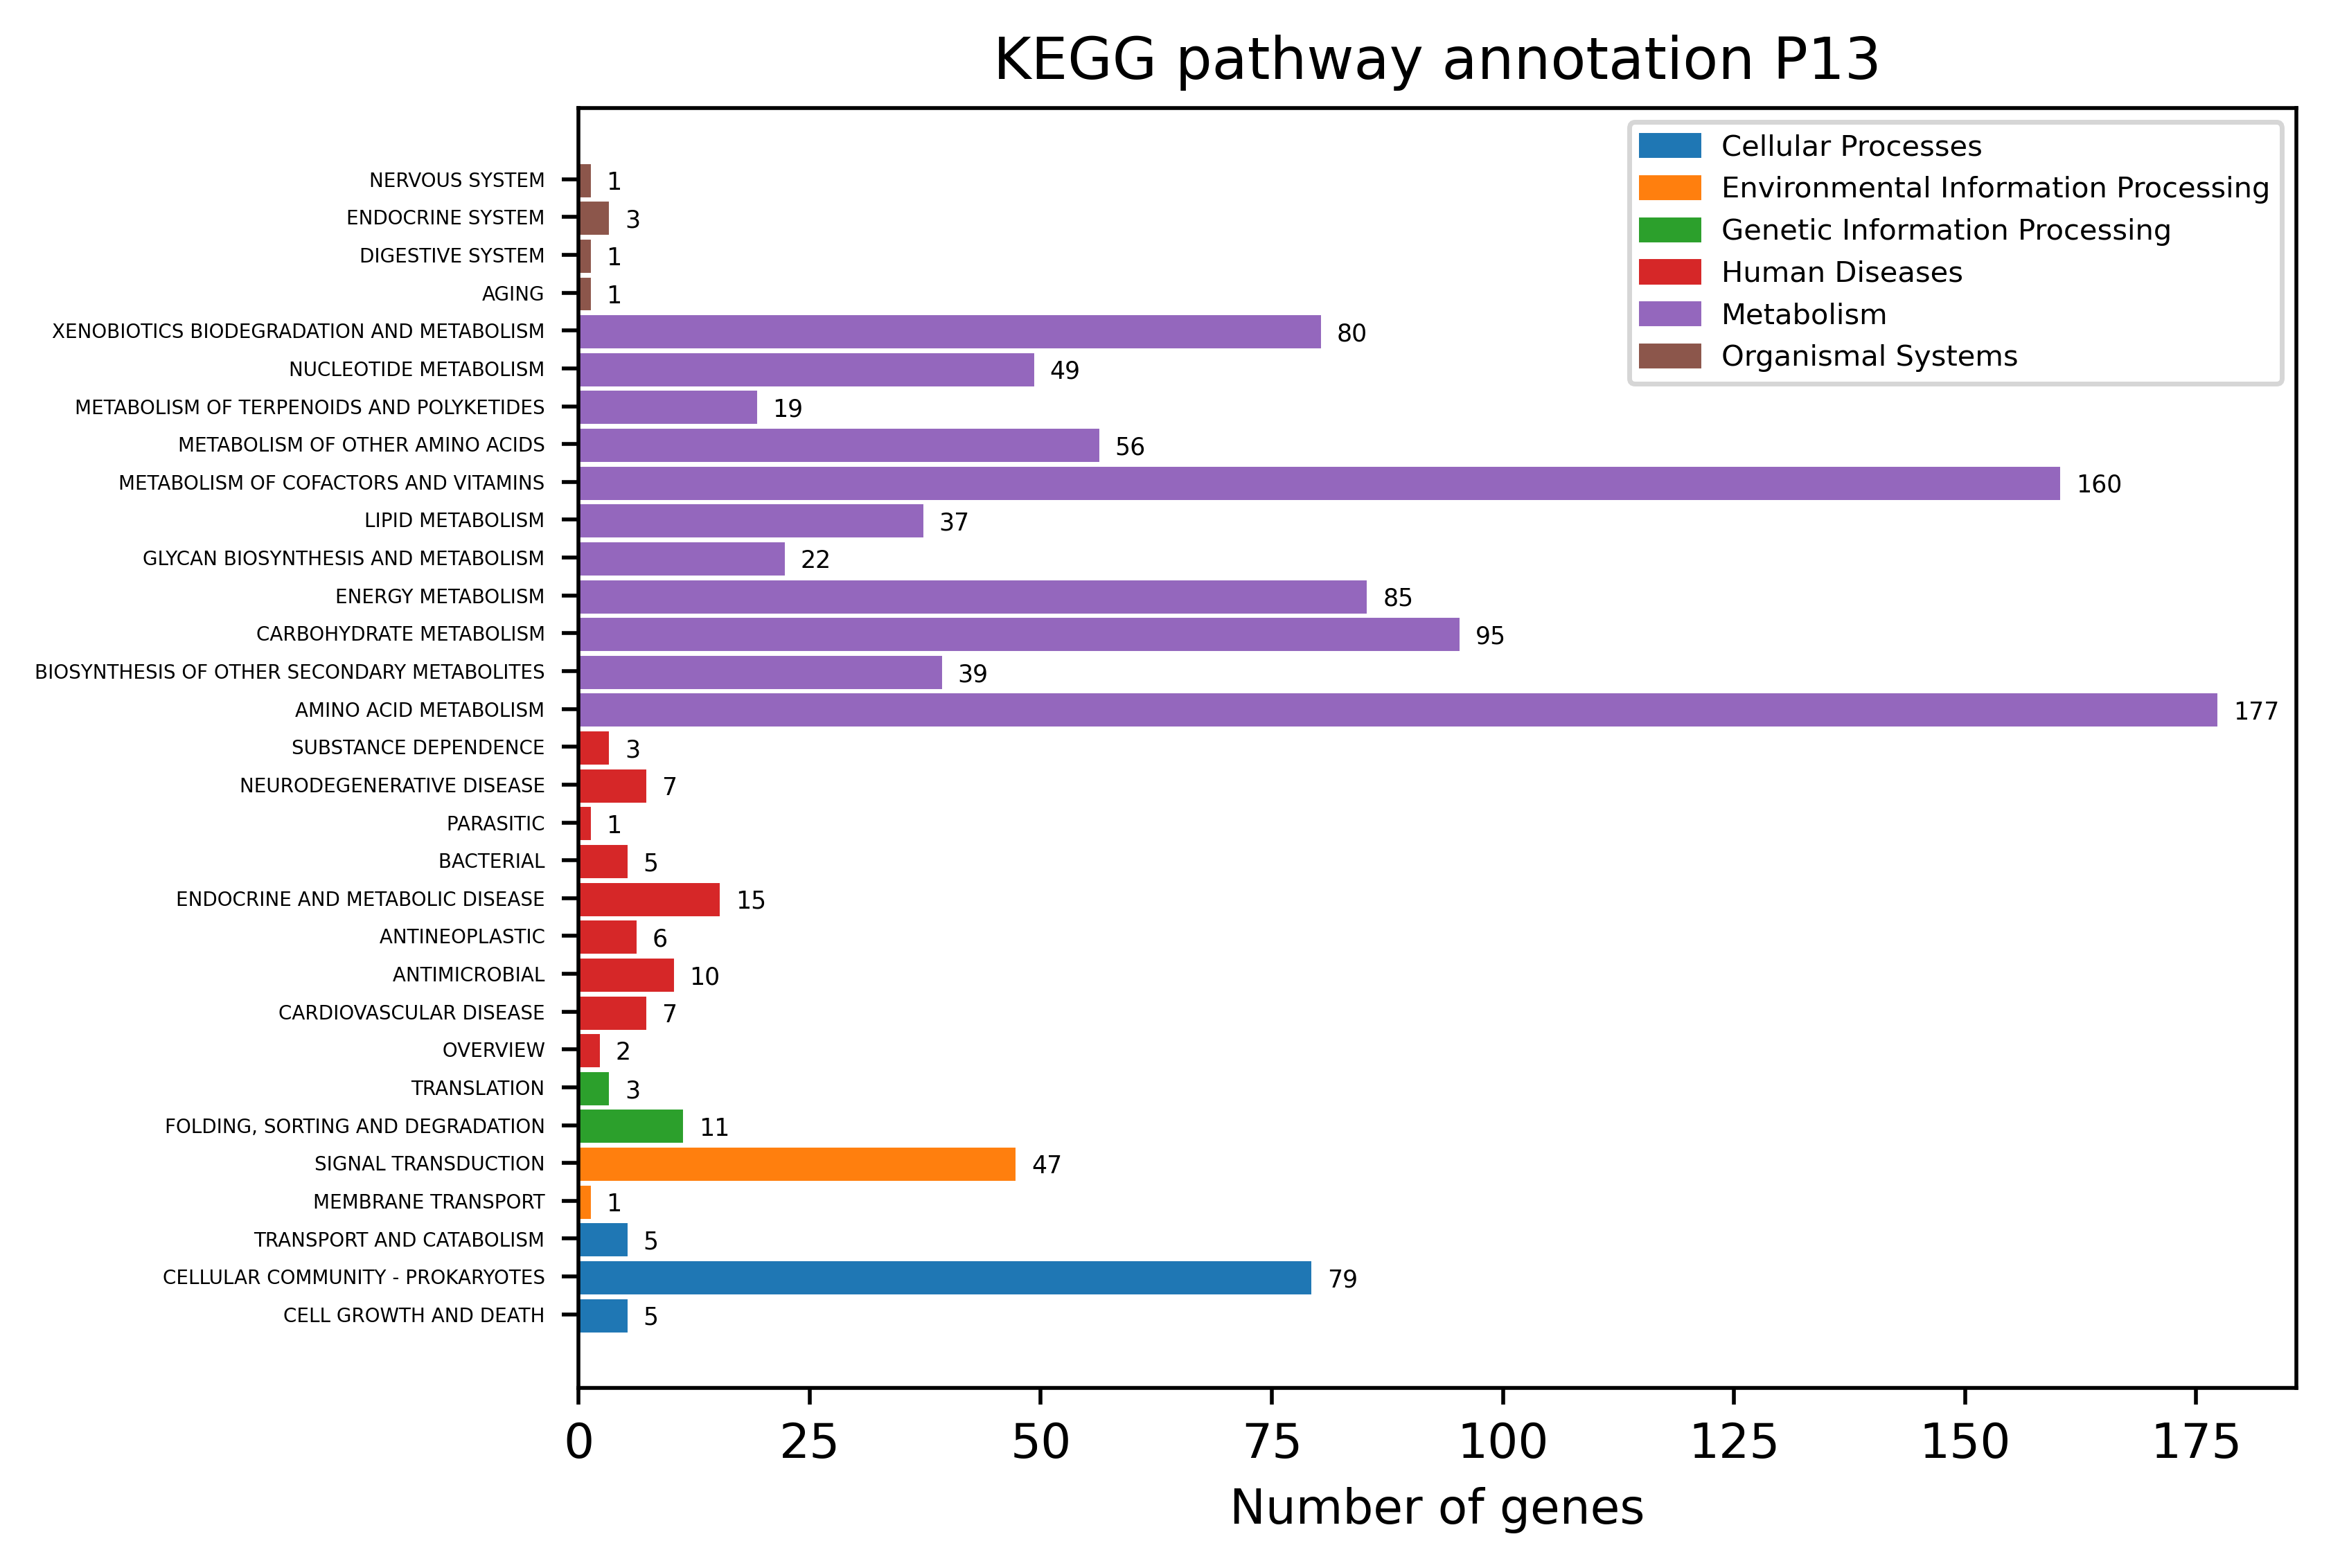

In [446]:
plot_pathway_distr(p13_distr, "P13")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 15360x11520 with 0 Axes>

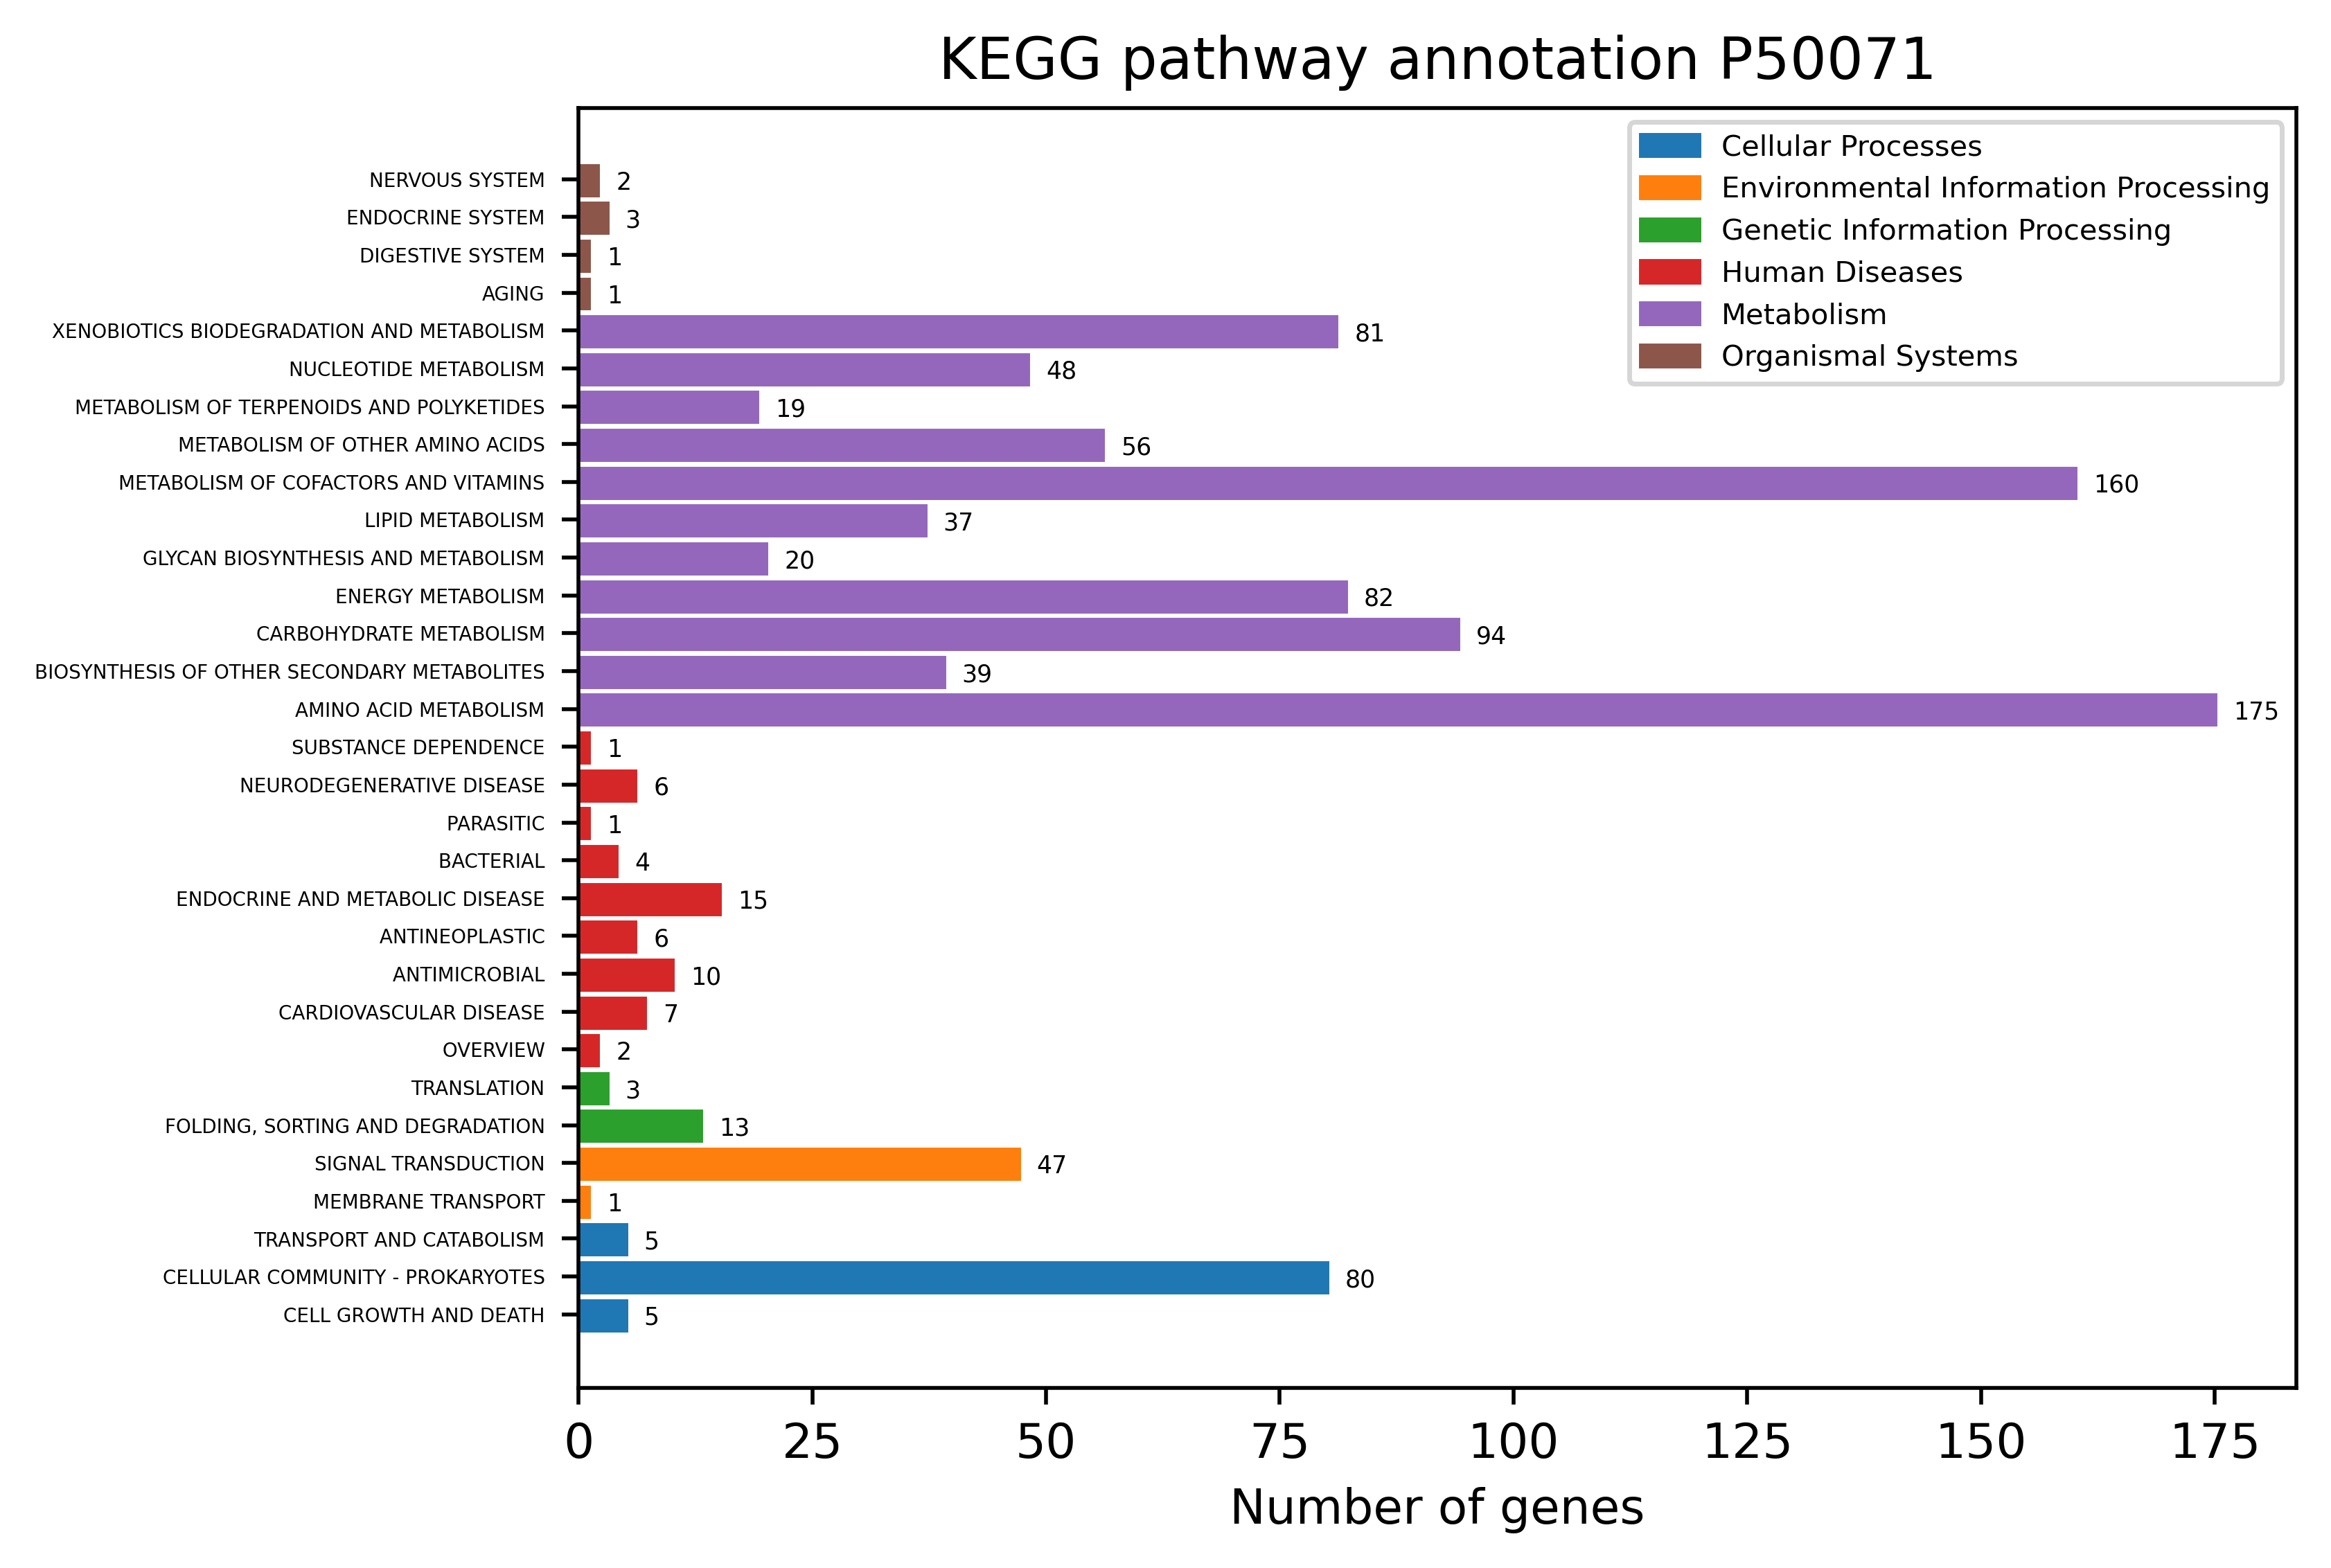

In [447]:
plot_pathway_distr(p50071_distr, "P50071")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 15360x11520 with 0 Axes>

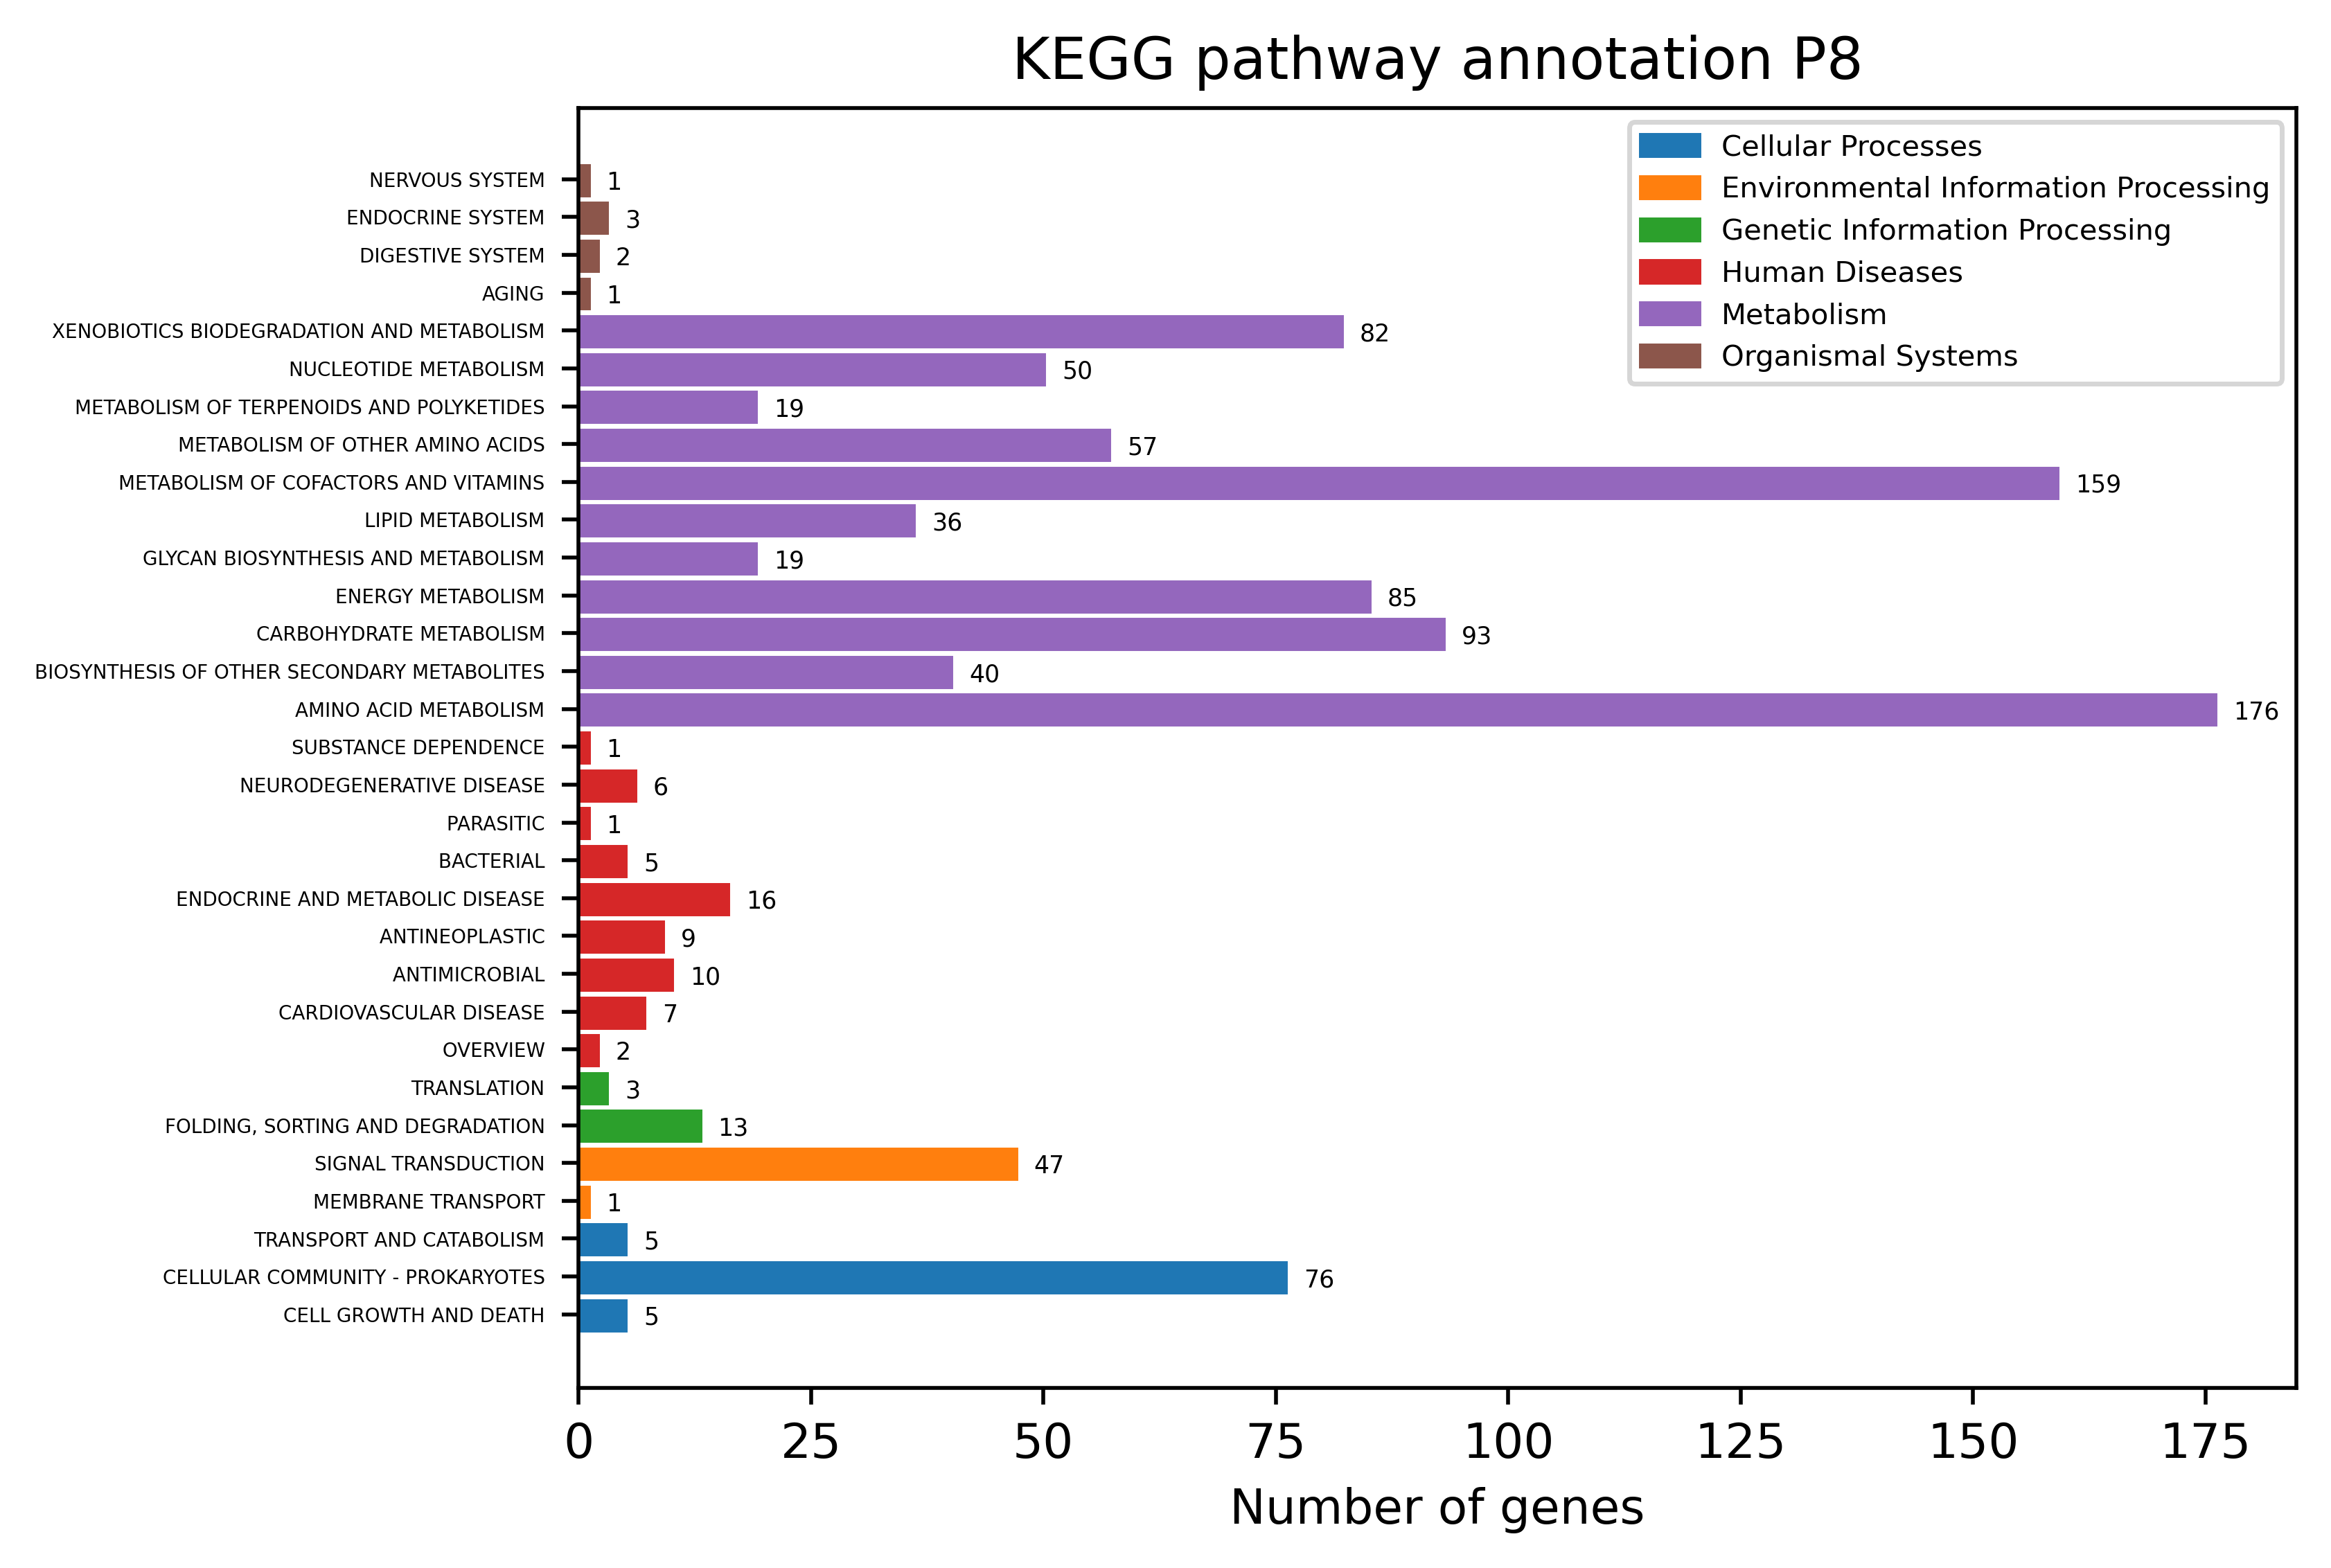

In [448]:
plot_pathway_distr(p8_distr, "P8")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 15360x11520 with 0 Axes>

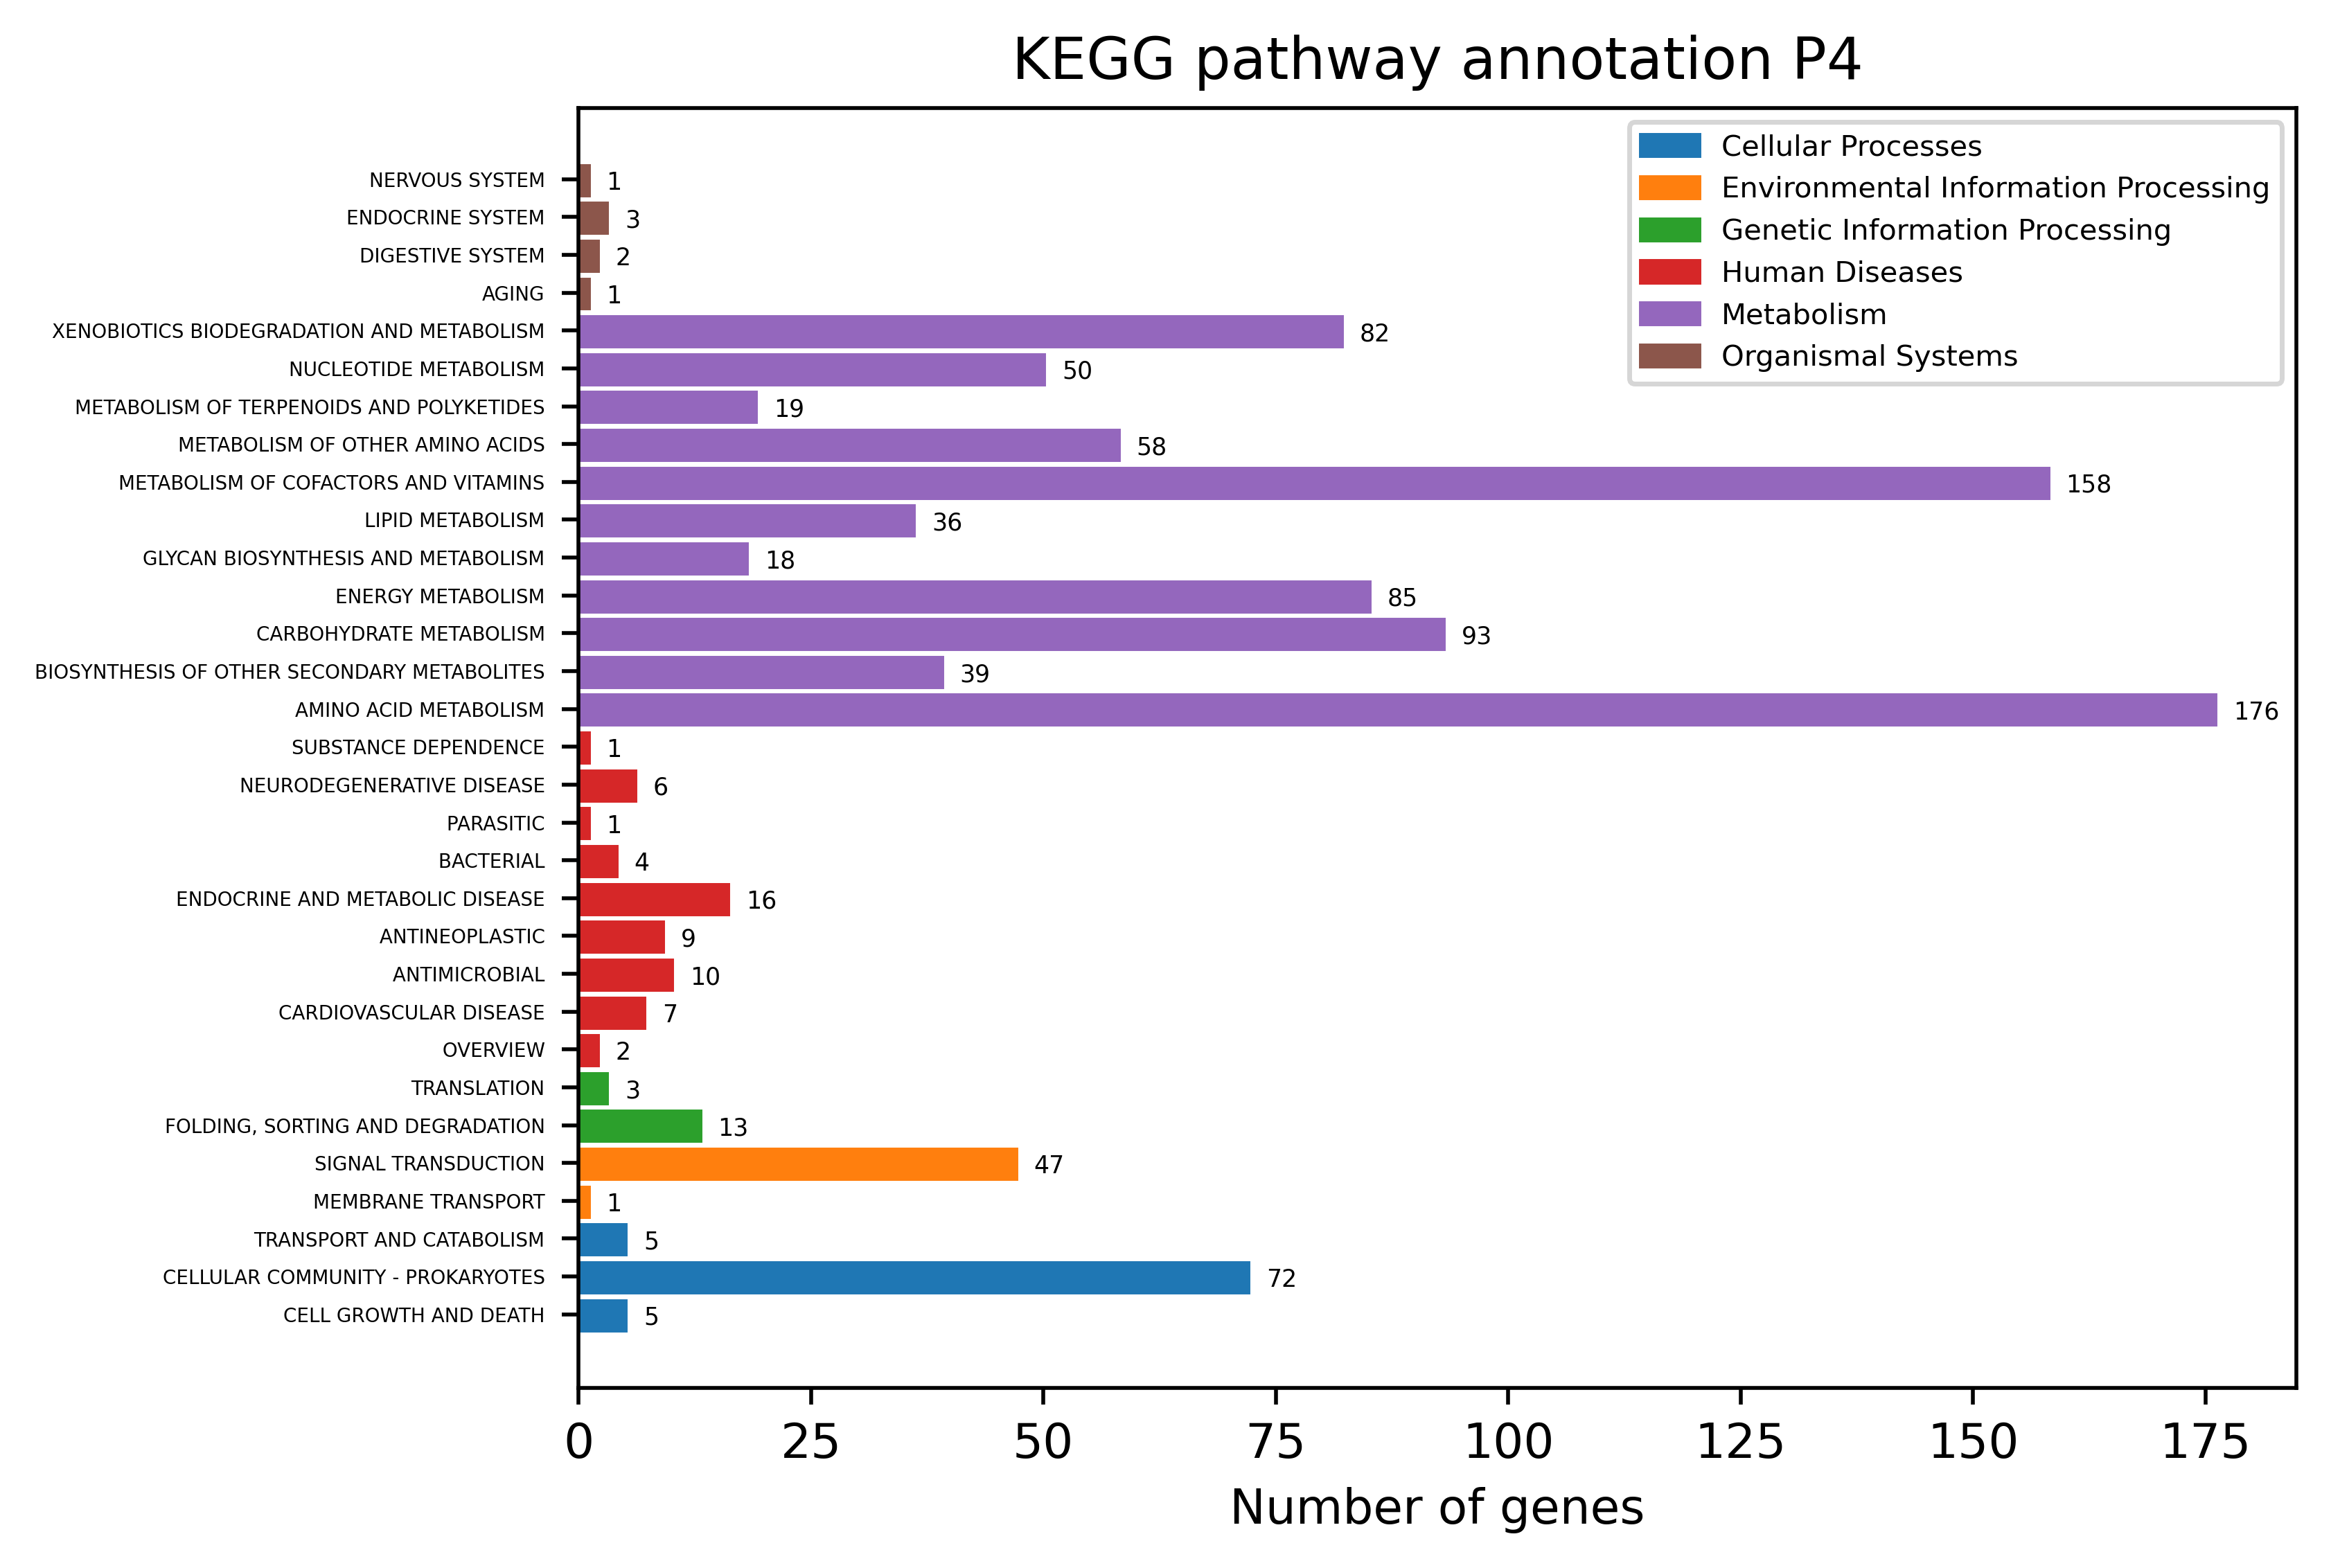

In [449]:
plot_pathway_distr(p4_distr, "P4")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 15360x11520 with 0 Axes>

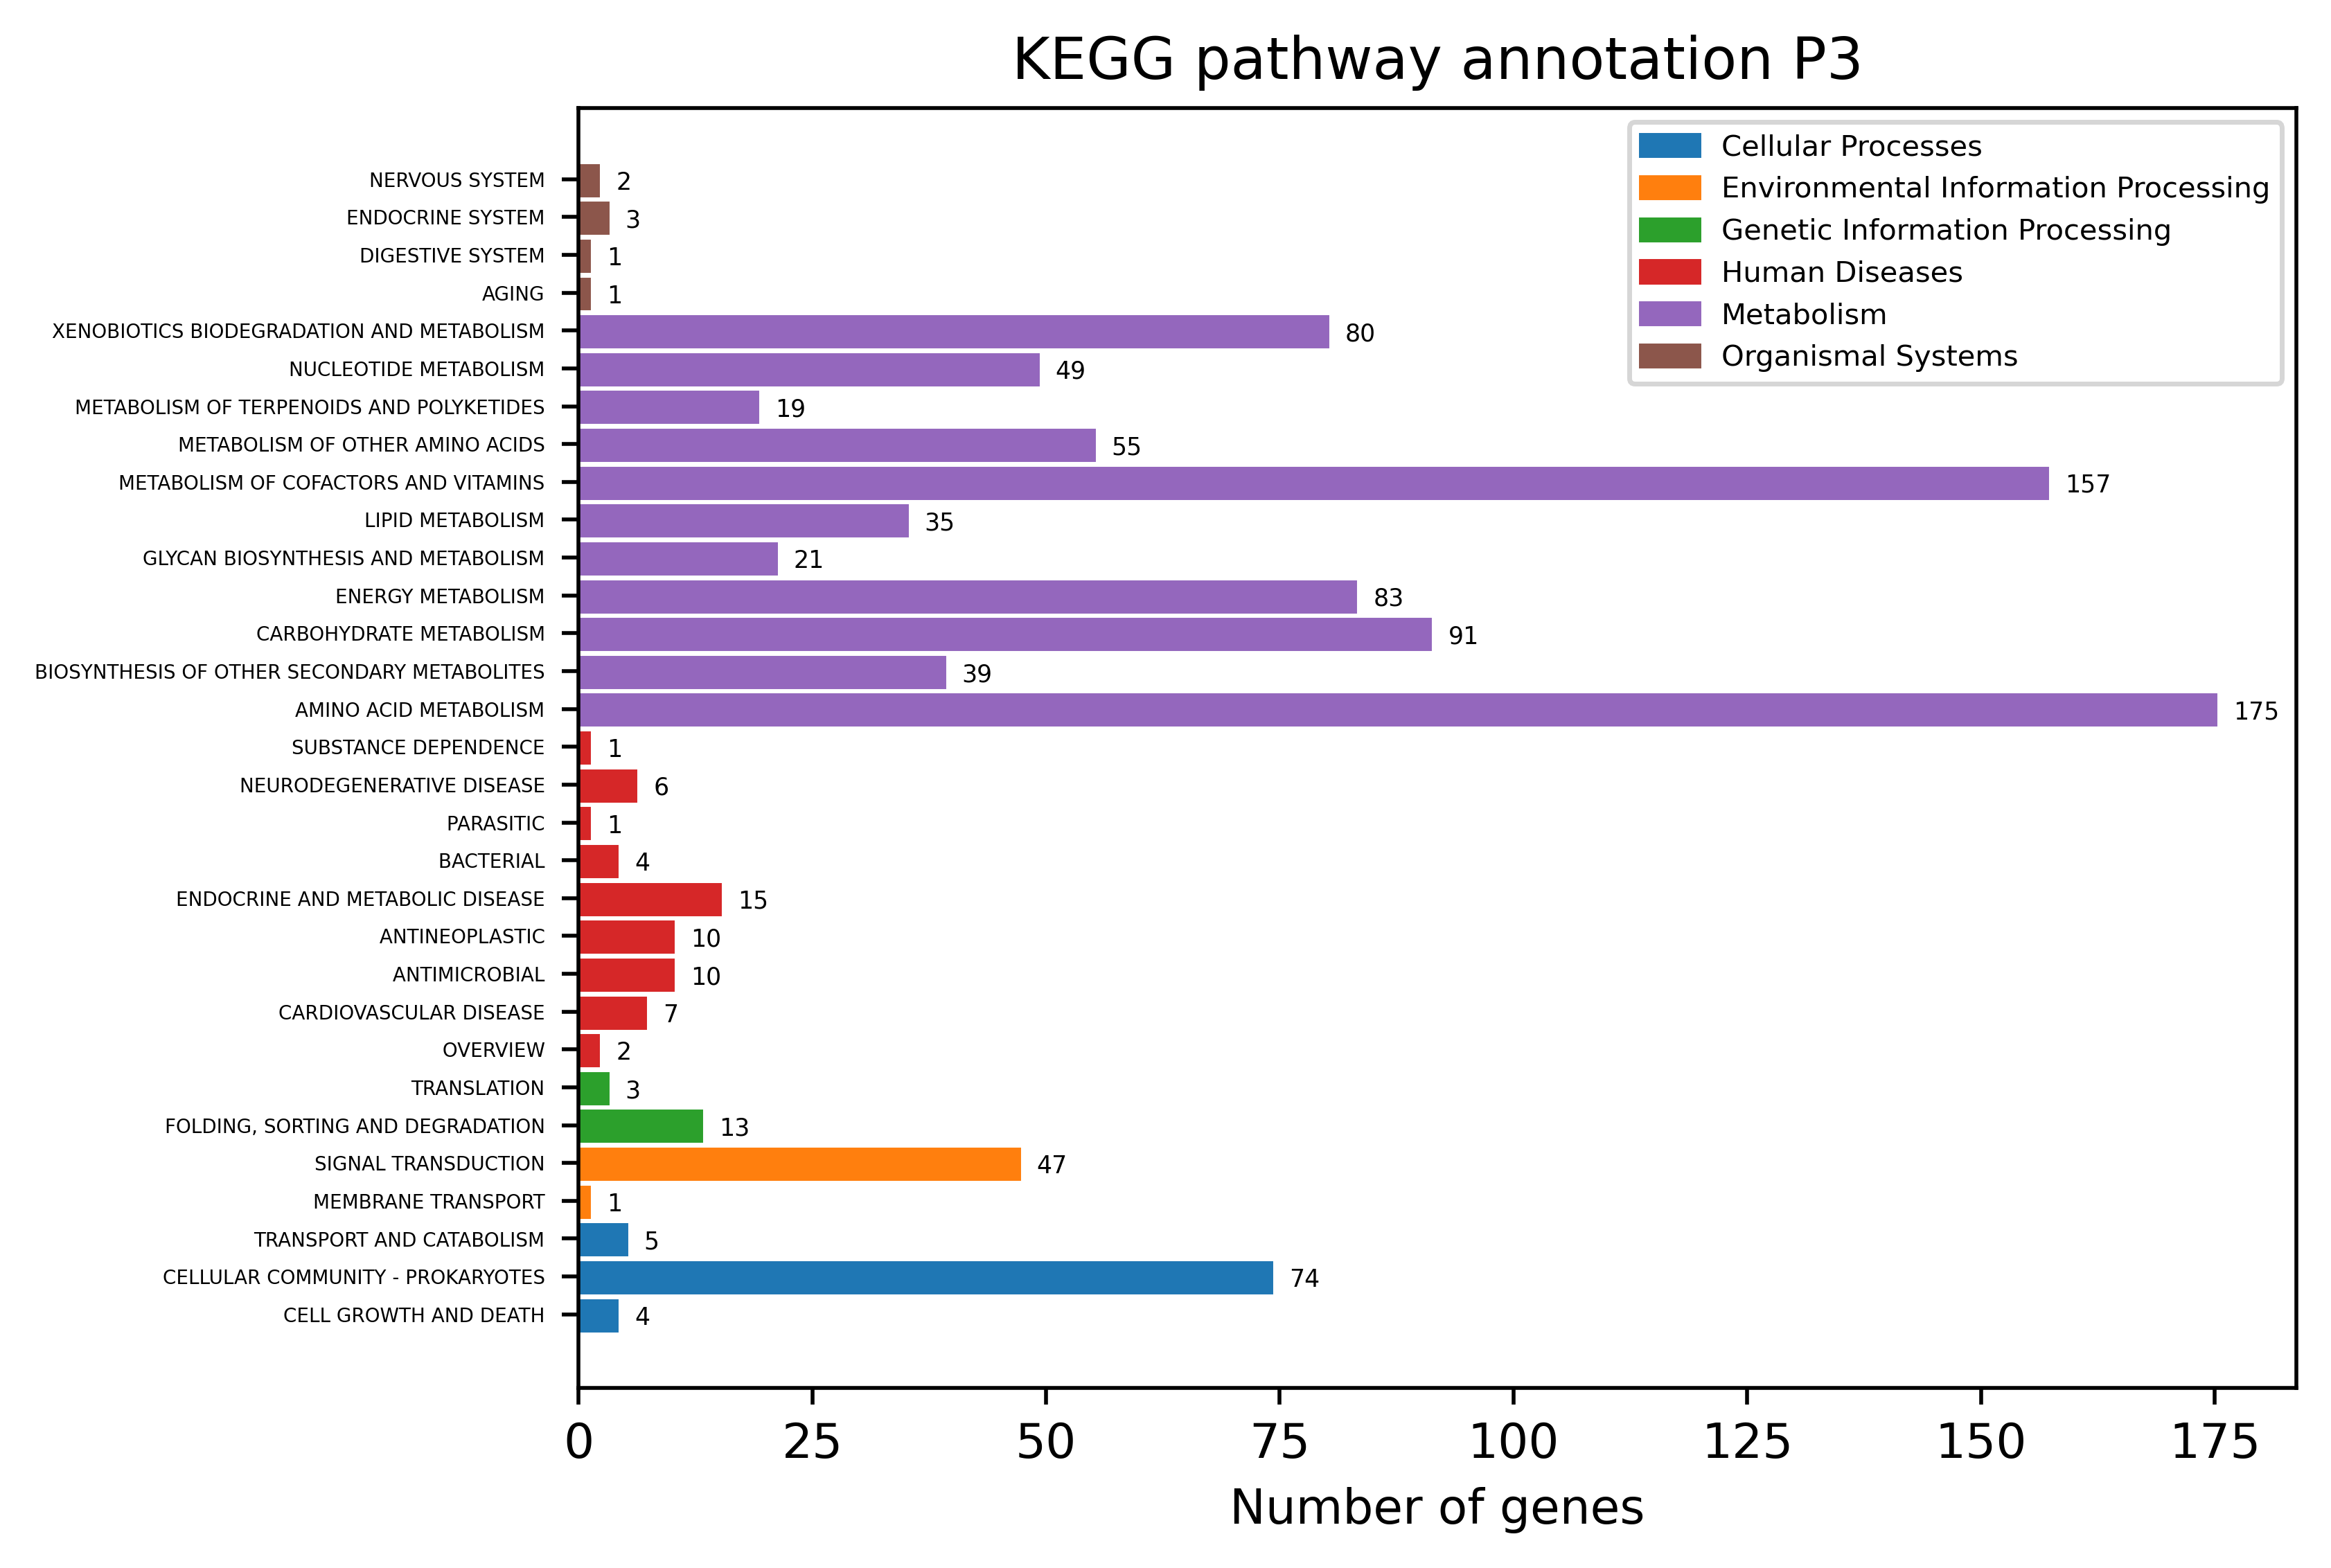

In [450]:
plot_pathway_distr(p3_distr, "P3")